# Field inference of a single (non-pointlike) source with the Fast Multipole Method

This notebook calcuates the potential of a single extended source via the Fast Multipole Method in 2D (https://github.com/flatironinstitute/fmm2d) as a comparison to an amortising statistical approximation.

In [1]:
import numpy as np
import fmm2dpy as fmm
import matplotlib.pyplot as plt
import scienceplots  # noqa
import warnings

from hypermagnetics import plots
from hypermagnetics.sources import configure

warnings.filterwarnings("ignore")
plt.style.use(["science", "ieee"])

## I. Target definition and data generation

We use a unformly magnetised single circular disc as the source; the form of the potential and field vary inside and outside the source and are evaluated using JAX via `hypermagnetics.sources.configure`. A general extended (non-pointlike) source will have, in two dimensions, the form $\mathbf{H}(\mathbf{r}) = - \mathbb{N}(\mathbf{r})\mathbf{M}$ inside the source. If the source has spherical symmetry,  by Gauss' Law it will have the dipole form $\mathbf{H} \sim \mathbf{H}_\odot$ outside it. The distinguishing feature of the dipole term is the $\sim 1/r$ dependence; higher multipole terms ($1/r^2$, $1/r^3$) might also be included, but the dipole term will quickly dominate at larger $r$.

2024-03-26 17:20:19.732048: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


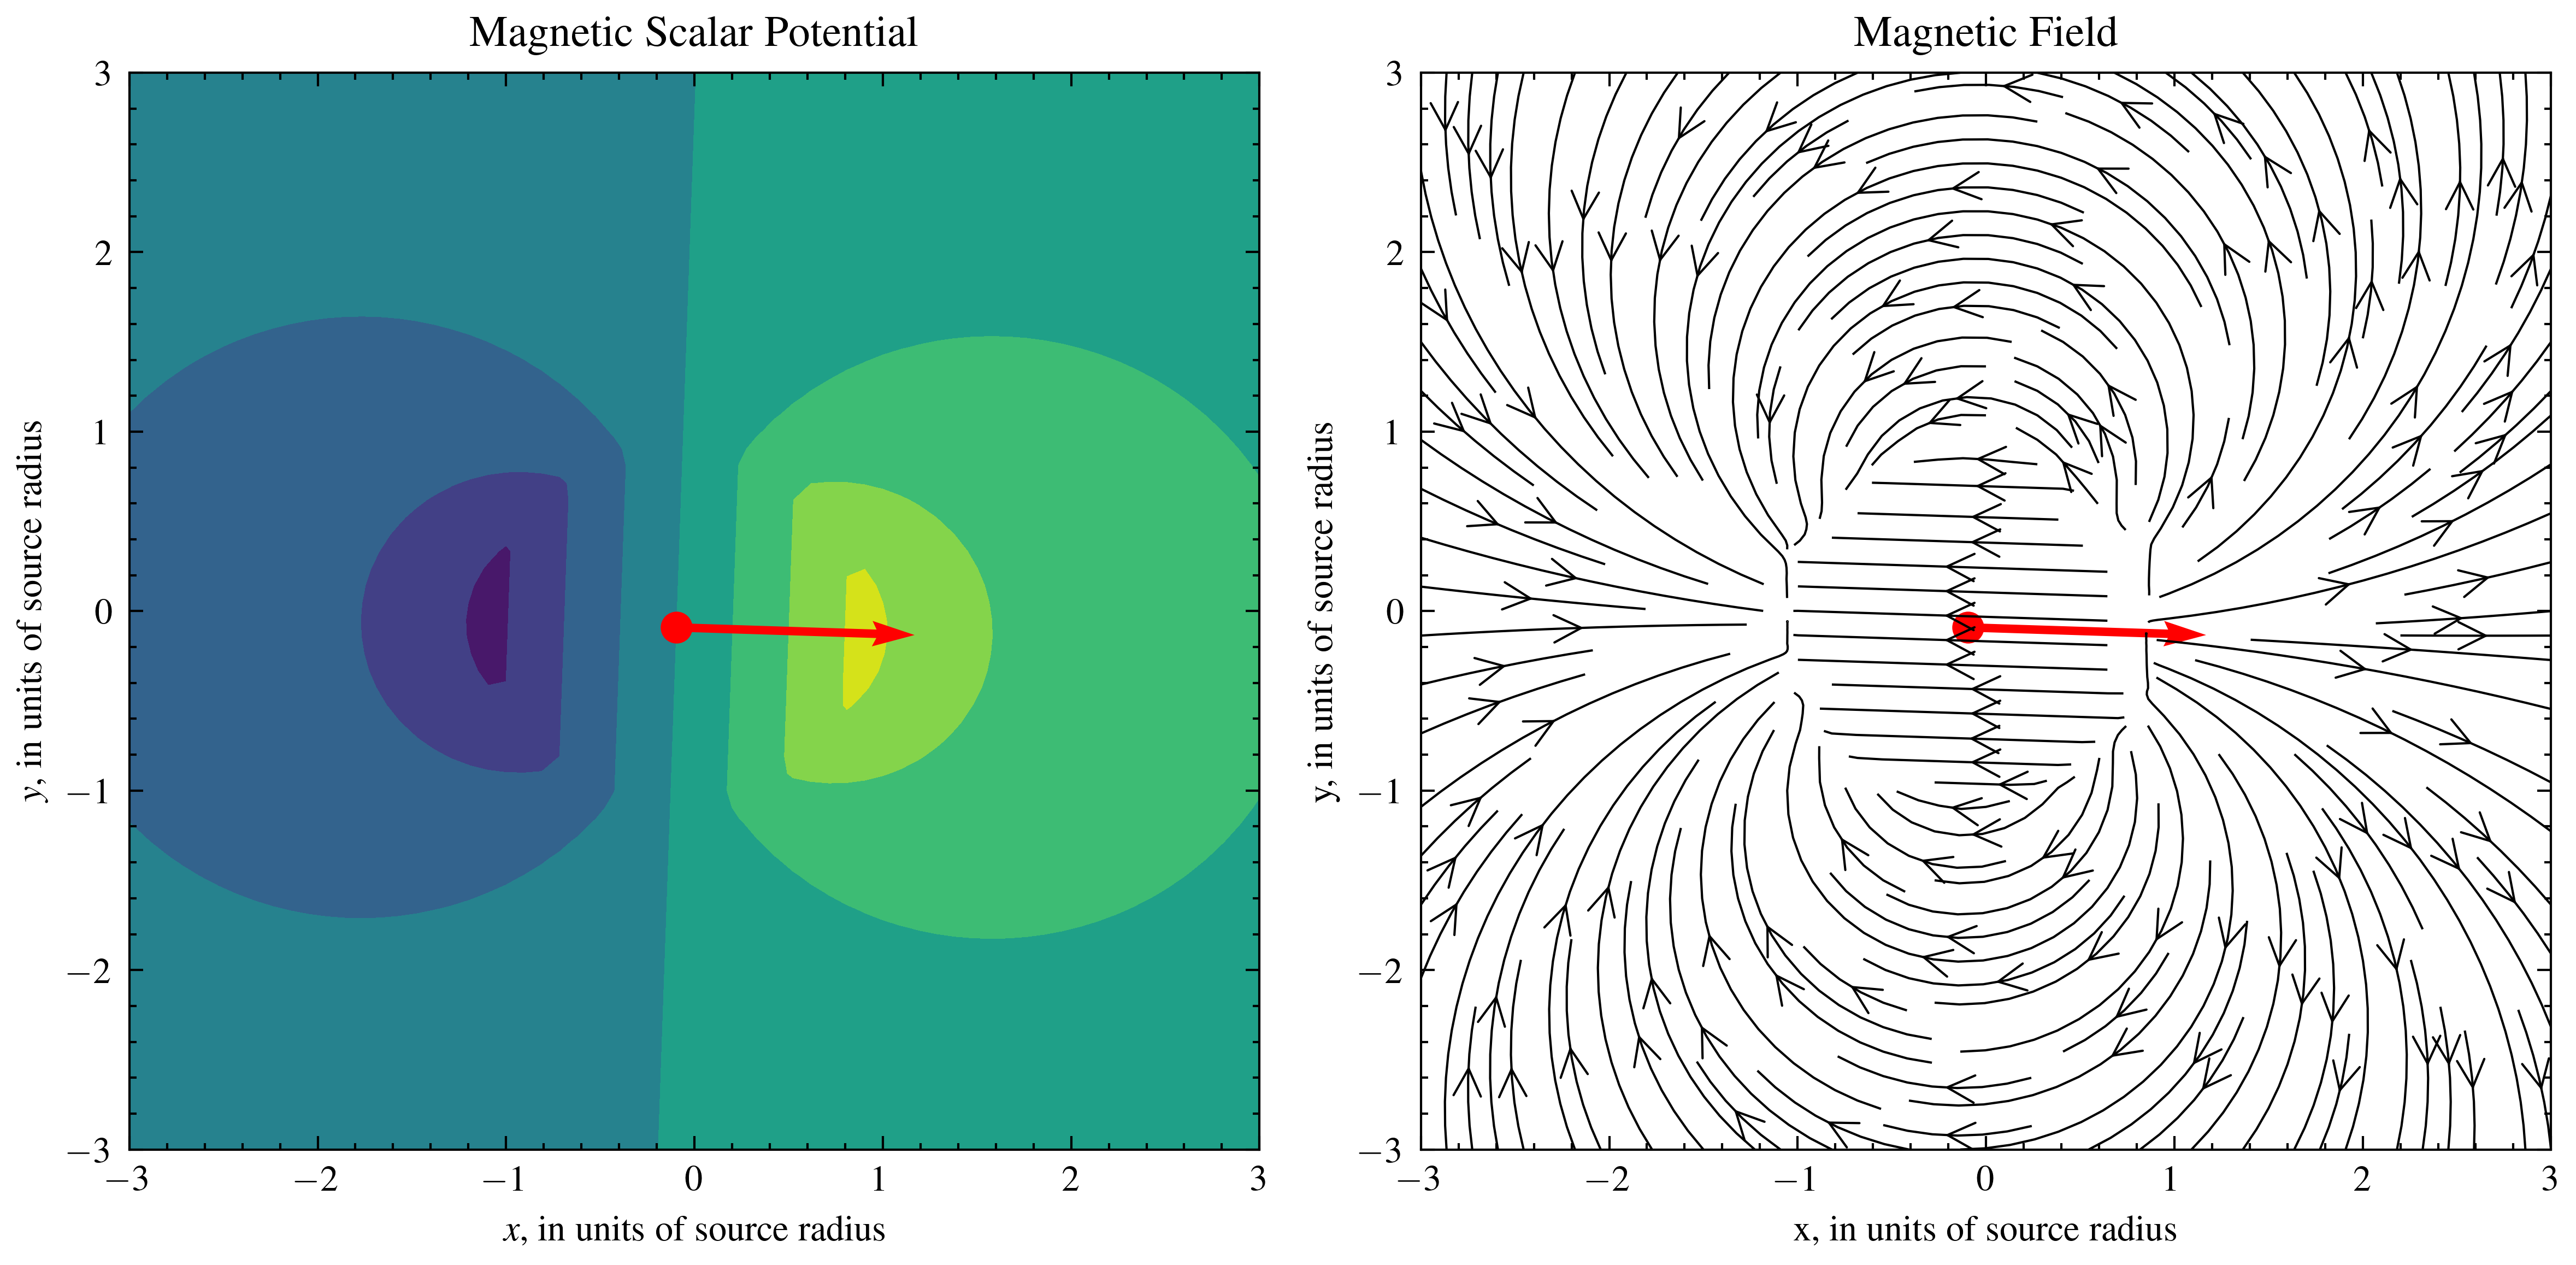

In [2]:
source_config = {
    "n_samples": 1,
    "lim": 3,
    "res": 64,
}
train = configure(**source_config, n_sources=1)
val = configure(**source_config, n_sources=4)
plots(train, None)

To achieve a solution via the FMM framework, we can try to imitate that by multiple pointlike dipoles inside the extended source. The dipole field at $\mathbf{r}$ from a collection of point-like sources with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential $${\mu_0}\mathbf{H}_{\odot}(\mathbf{r}) = -\nabla\sum_{i=1}^N \frac{1}{2\pi |\mathbf{r}-\mathbf{r_i}|}\frac{\mathbf{m}_i\cdot(\mathbf{r}-\mathbf{r_i})}{|\mathbf{r}-\mathbf{r_i}|}.$$

 Reallocating
 Reallocating
 Reallocating
 Reallocating
 Reallocating


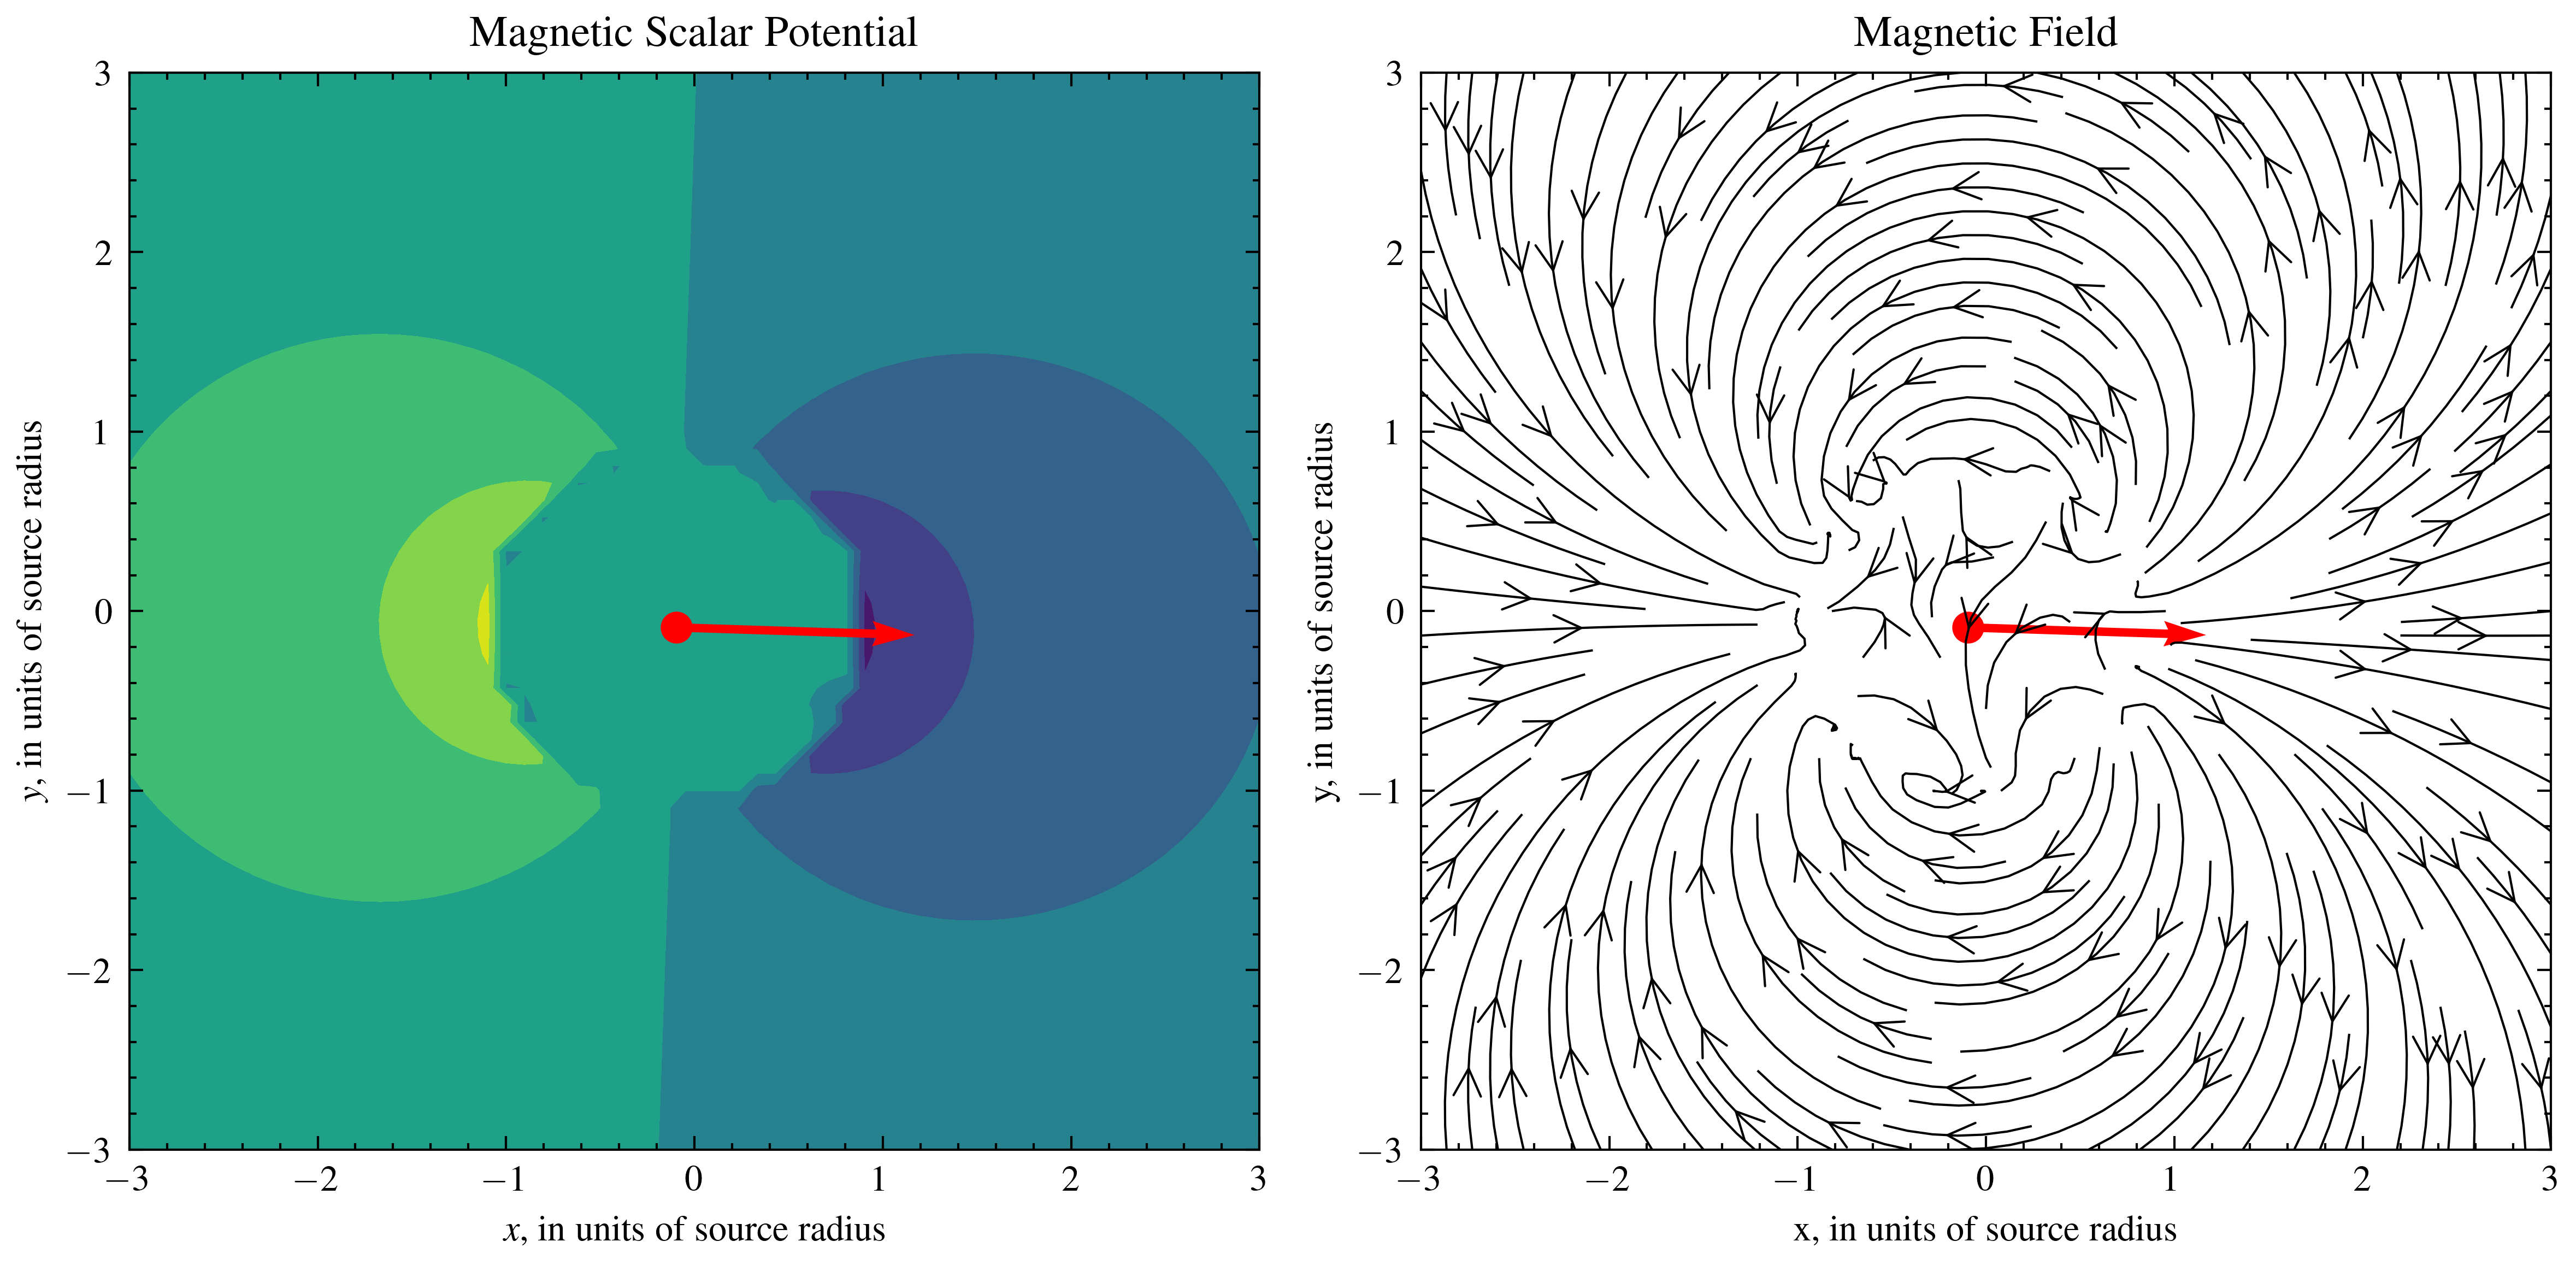

In [5]:
sim_ball = train.copy()

idx = 0
mr = sim["sources"][idx : idx + 1]
m, r0 = np.split(mr, 2, axis=-1)

ns = 2000000  # number of source poitns
radius = 1  # radius of circle

# generate n random angles
angles = np.random.uniform(0, 2 * np.pi, ns)

# convert angles to Cartesian coordinates
x = radius * np.cos(angles) + r0[0][0][0]
y = radius * np.sin(angles) + r0[0][0][1]

points = np.column_stack((x, y)).swapaxes(0, 1)

dipstr = np.sqrt(m[0][0][0] ** 2 + m[0][0][1] ** 2)
dipvec = m[0].swapaxes(0, 1) / dipstr

out = fmm.lfmm2d(
    eps=10 ** (-5),
    sources=points,
    dipstr=np.repeat(np.array([dipstr]), repeats=ns, axis=-1),
    dipvec=np.repeat(dipvec, repeats=ns, axis=-1),
    targets=train["grid"].swapaxes(0, 1),
    nd=source_config["n_samples"],
    pg=0,
    pgt=2,
)
sim_ball["potential_grid"] = np.array([out.pottarg])
sim_ball["field_grid"] = np.real(np.array([out.gradtarg.swapaxes(0, 1)]))
plots(sim_ball, None)

As noted in [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0021999108004233), for the far-field evaluation the FMM approximation is extremely good, as we can verify by evaluating on larger length scales.

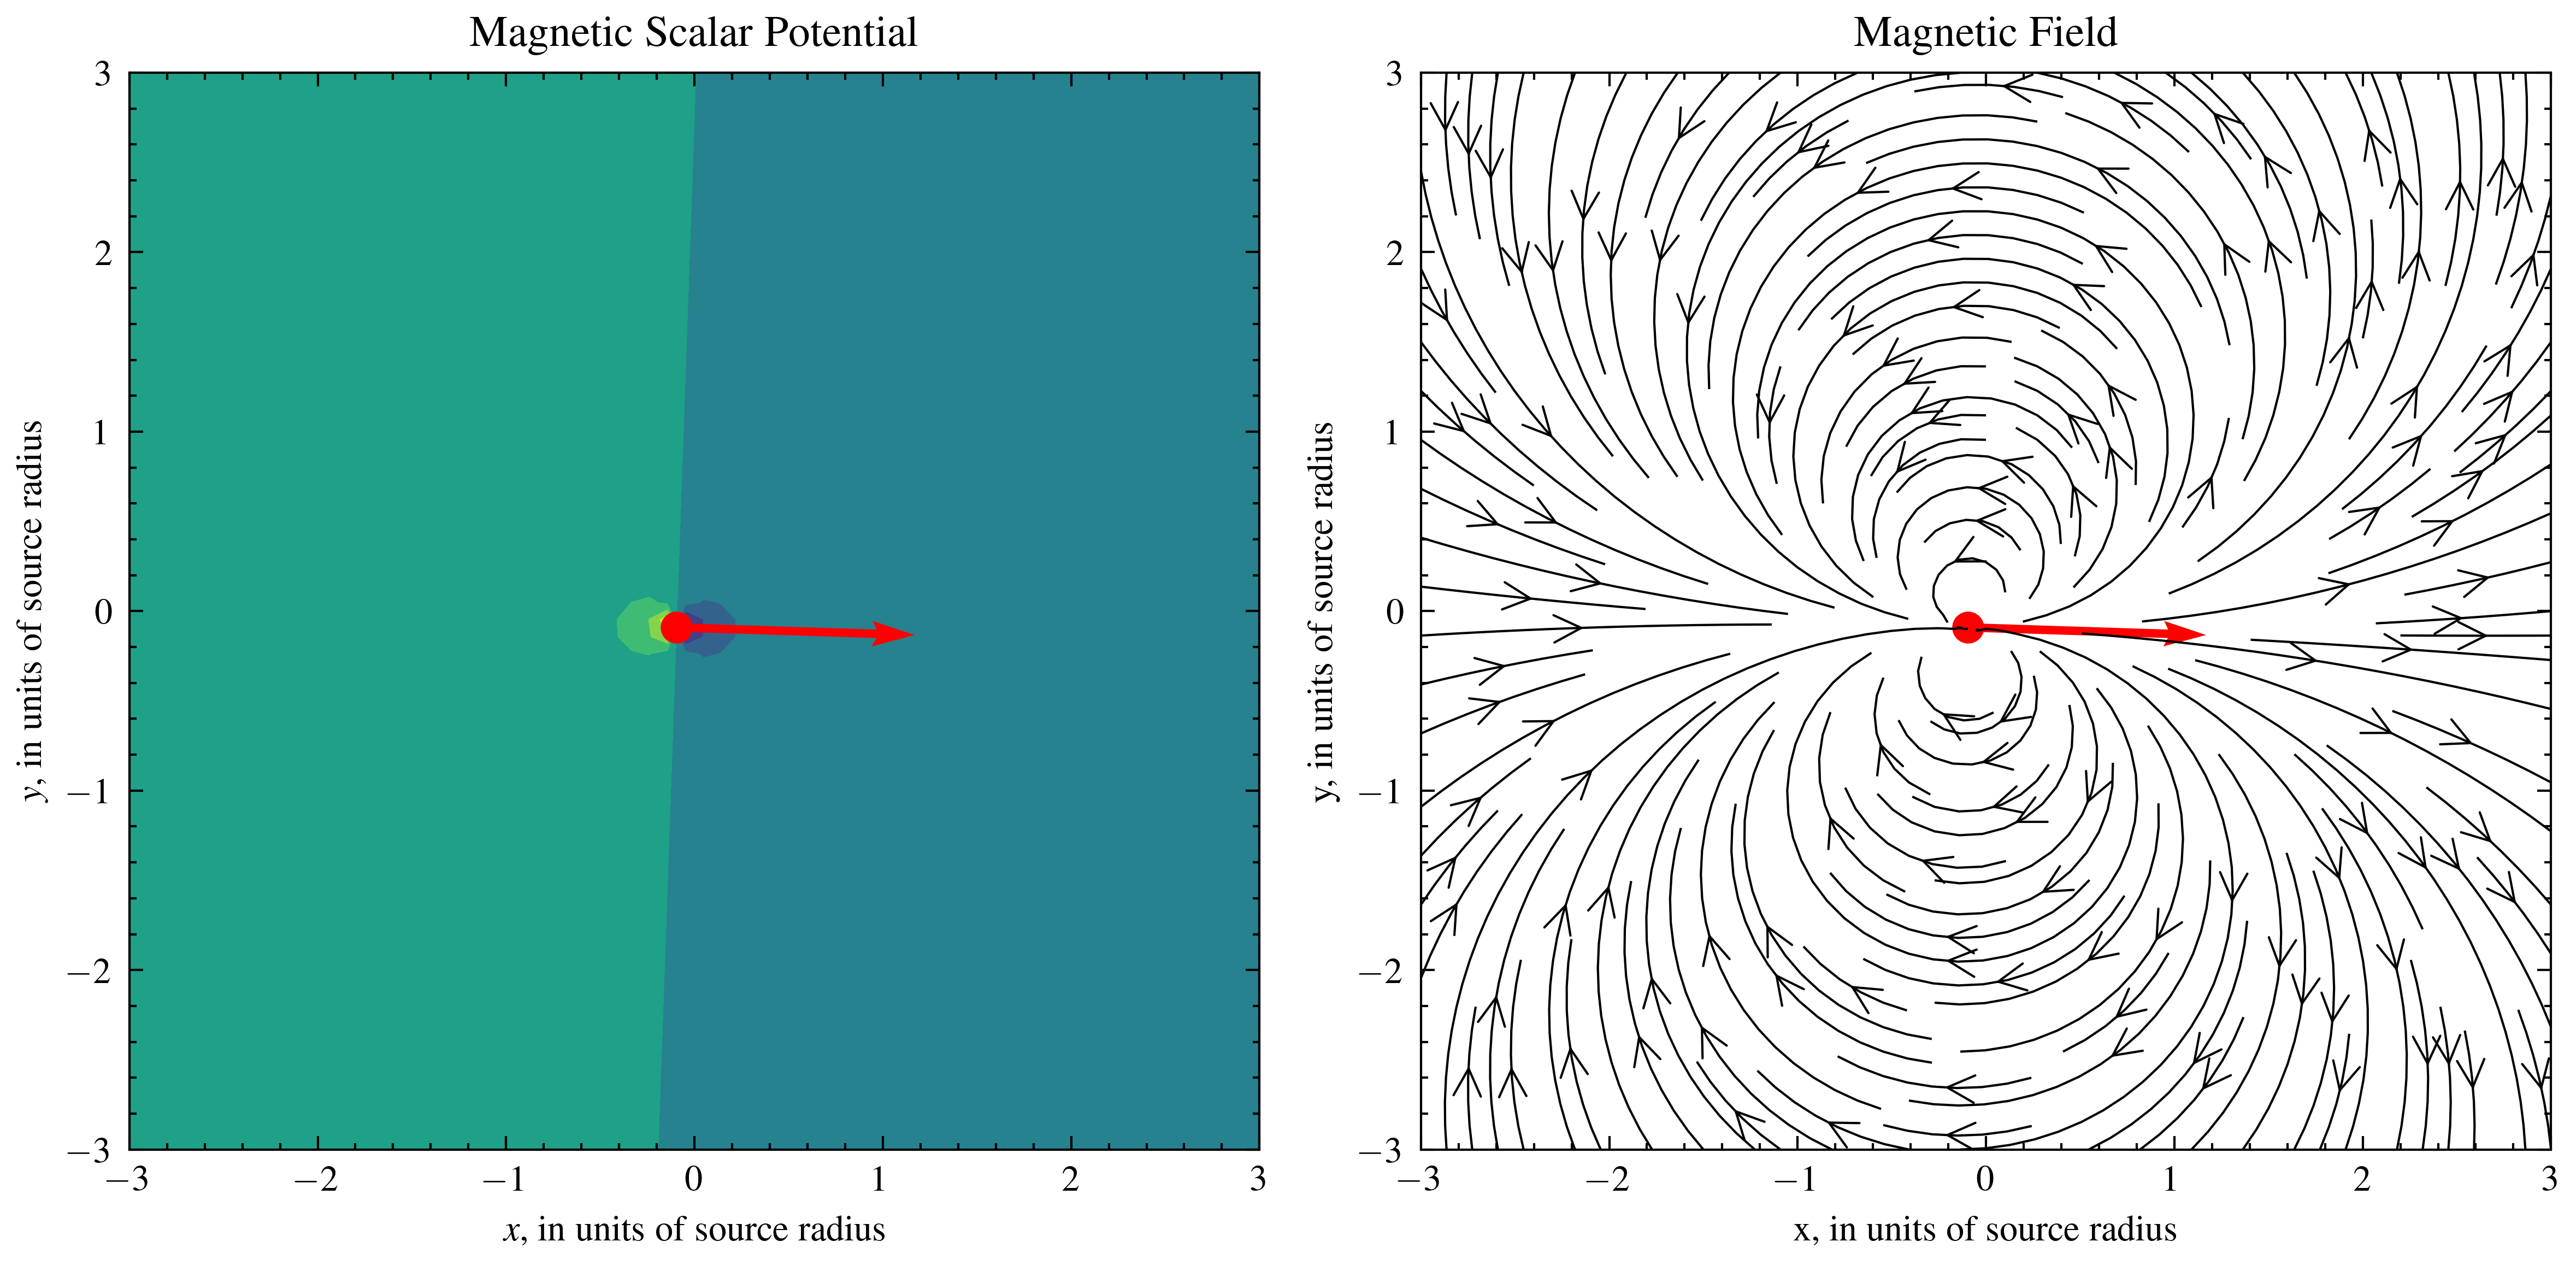

In [3]:
sim = train.copy()

mr = sim["sources"][0:1]
m, r0 = np.split(mr, 2, axis=-1)
loc = r0[0].swapaxes(0, 1)
dipstr = np.array([np.sqrt(m[0][0][0] ** 2 + m[0][0][1] ** 2)])
dipvec = m[0].swapaxes(0, 1) / dipstr

out = fmm.lfmm2d(
    eps=10 ** (-5),
    sources=loc,
    dipstr=dipstr,
    dipvec=dipvec,
    targets=train["grid"].swapaxes(0, 1),
    nd=source_config["n_samples"],
    pg=0,
    pgt=2,
)
sim["potential_grid"] = np.array([out.pottarg])
sim["field_grid"] = np.real(np.array([out.gradtarg.swapaxes(0, 1)]))
plots(sim, None)